# Sentiment analysis
part separating every, part adding the analysis over time for some selected movies

In [18]:
# import nltk
import pandas as pd

from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.sentiment import SentimentIntensityAnalyzer

from joblib import Parallel, delayed
from tqdm import tqdm

import matplotlib.pyplot as plt
import seaborn as sns
import json
import re

Loading dataset

In [3]:
df = pd.read_csv("Merged_Reviews_and_Metadata.csv")
df.shape, df.columns

C:\Users\mia\AppData\Local\Temp\ipykernel_34712\1703312556.py:1: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("Merged_Reviews_and_Metadata.csv")


((1341856, 15),
 Index(['rating', 'review_title', 'text', 'asin', 'parent_asin', 'user_id',
        'timestamp', 'helpful_vote', 'main_category', 'movie_title',
        'average_rating', 'rating_number', 'description', 'price',
        'categories'],
       dtype='object'))

Analysis of all review. Providing a general overlook of sentiment

In [4]:
#Change to something that makes sense for your PC
threads = 8
neutral_threshold = 0.1  # Bin around 0 that indicate a neutral sentiment

# Function to process a batch of reviews
def analyze_batch_sentiment(batch):
    sia = SentimentIntensityAnalyzer()
    return [sia.polarity_scores(str(text))['compound'] for text in batch]

# More is faster but uses more resources
batch_size = 10000

# Batch Generator
batches = [df['text'][i:i + batch_size] for i in range(0, len(df), batch_size)]

with tqdm(desc="Sentiment Analysis", total=len(batches)):
    sentiment_scores_batches = Parallel(n_jobs=threads)(
        delayed(analyze_batch_sentiment)(batch) for batch in batches
    )

# Flatten the list of batches into a single list
sentiment_scores = [score for batch_scores in sentiment_scores_batches for score in batch_scores]

# Add sentiment score and category to dataframe
df['sentiment_score'] = sentiment_scores
df['sentiment_category'] = df['sentiment_score'].apply(
    lambda x: 'positive' if x > neutral_threshold else ('negative' if x < -neutral_threshold else 'neutral')
)

Sentiment Analysis:   0%|          | 0/135 [03:31<?, ?it/s]


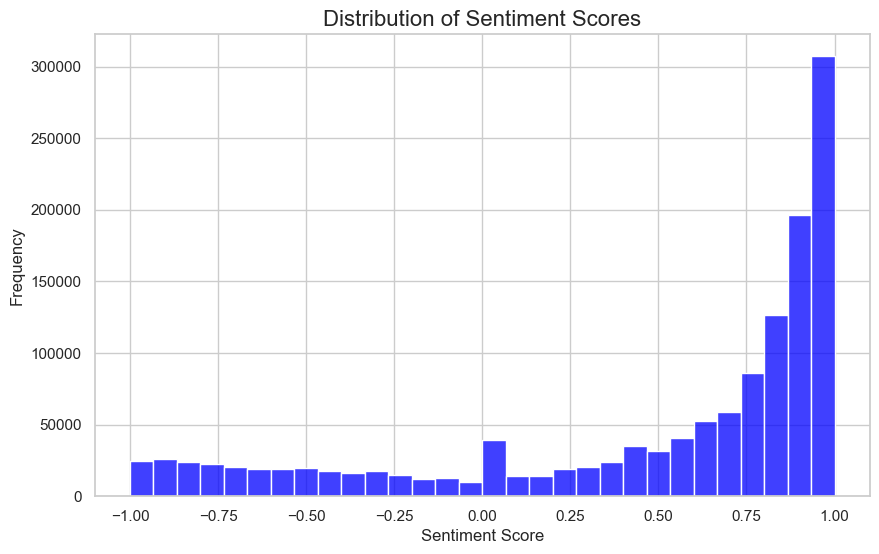

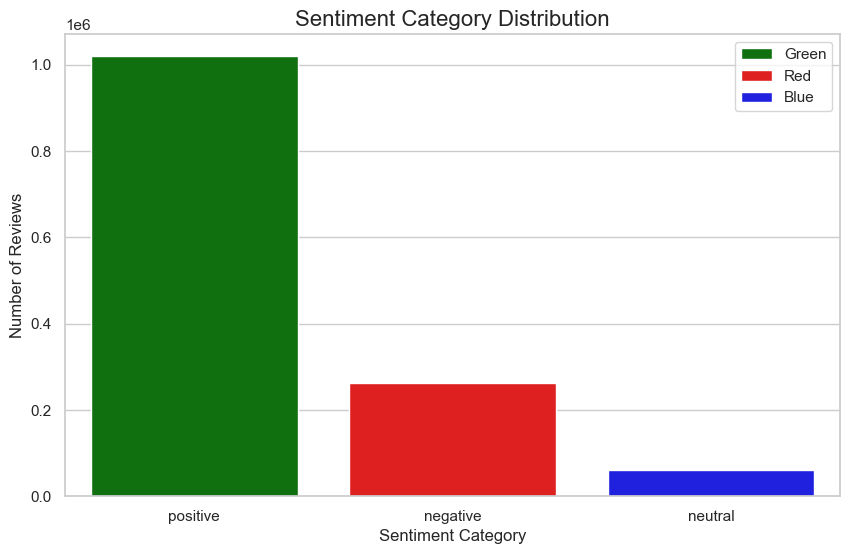

In [5]:
sns.set(style="whitegrid")

# Distribution of sentiment scores
plt.figure(figsize=(10, 6))
sns.histplot(df['sentiment_score'], kde=False, bins=30, color='Blue')
plt.title('Distribution of Sentiment Scores', fontsize=16)
plt.xlabel('Sentiment Score', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.show()

# Sentiment Category Histogram
sentiment_counts = df['sentiment_category'].value_counts()

colors = ['Green', 'Red', 'Blue']  # Positive, Negative, Neutral
plt.figure(figsize=(10, 6))
sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values, palette=colors, hue=colors)
plt.title('Sentiment Category Distribution', fontsize=16)
plt.xlabel('Sentiment Category', fontsize=12)
plt.ylabel('Number of Reviews', fontsize=12)
plt.show()

# Finding most reviewed item, of the reviews that we have

In [ ]:
df.groupby(by="parent_asin")["user_id"].nunique().sort_values(ascending=False)

parent_asin
B093CNZ7ST    3923
B0000AQS0F    1504
B0094V8OXG    1373
B003ZSJ212    1131
B009ZQ8FQG     914
              ... 
B000HOJR6C      11
B001CIOCPI      11
B0002CHI2Y      10
B00D8MWW26       9
B00006673Q       8
Name: user_id, Length: 21414, dtype: int64

In [ ]:
top_5 = df.groupby(by="parent_asin")["user_id"].nunique().sort_values(ascending=False).head(5).index
top_5 = list(top_5)
top_5

['B093CNZ7ST', 'B0000AQS0F', 'B0094V8OXG', 'B003ZSJ212', 'B009ZQ8FQG']

In [ ]:
df[df["parent_asin"].isin(top_5)]

,rating,title_x,text,asin,parent_asin,user_id,timestamp,helpful_vote,main_category,title_y,average_rating,rating_number,description,price,sentiment_score,sentiment_category
63,5.0,Fantastic Costume Drama!,This is one of the best British costume dramas...,B009ZQ8FQG,B009ZQ8FQG,AEWLOQTKYUYRJ24NK4GD5CZTR7WA,1359640538000,1,Prime Video,Downton Abbey,4.9,38901.0,['The war is over and a long-awaited engagemen...,19.99,0.9138,positive
201,5.0,"A must-have for any sci-fi, Firefly, or Castle...","I discovered Firefly after watching Castle, an...",B0000AQS0F,B0000AQS0F,AF224BZVIYKHVGJGPKGC3UAVTLQQ,1365086098000,1,Movies & TV,Firefly: The Complete Series,4.8,11989.0,"['Product Description', ""Episodes: -Serenity-p...",13.62,0.9188,positive
255,5.0,He hates us. He tested the waters as far ...,He hates us. He tested the waters as far as wh...,B0094V8OXG,B0094V8OXG,AH36C2YF45UIU7MKNJLFMM3BDVEA,1473370184000,3,Movies & TV,2016: Obama’s America,4.4,5395.0,"['Product Description', ""Immersed in exotic lo...",9.9,-0.5983,negative
322,4.0,Torn Between Star Ratings,On one hand it's well acted with a decent prem...,B093CNZ7ST,B093CNZ7ST,AFUSWNVA72MMWHGYWJ652SYX2JJQ,1625436696995,1,Prime Video,The Tomorrow War,4.1,33247.0,['Time travelers arrive from 2051 to deliver a...,NaN,-0.9898,negative
552,5.0,Downton Abbey,I missed the seasons on PBS but loved it on Am...,B009ZQ8FQG,B009ZQ8FQG,AGD6NXJR2PRZMLVI7H6W35SYURQA,1358826661000,1,Prime Video,Downton Abbey,4.9,38901.0,['The war is over and a long-awaited engagemen...,19.99,0.9827,positive
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
754830,5.0,Great Movie,Loved Sam Richardson!! Couldn't stop laughing ...,B093CNZ7ST,B093CNZ7ST,AHRWO4BX32KTRYW3H5QT7NLYFADA,1625779735463,1,Prime Video,The Tomorrow War,4.1,33247.0,['Time travelers arrive from 2051 to deliver a...,NaN,0.8606,positive
755179,5.0,Great Action Movie!,This was the perfect amount of action and hear...,B093CNZ7ST,B093CNZ7ST,AH6MV3J7JVEUK55EQZBITZ4YGKPA,1625216567939,1,Prime Video,The Tomorrow War,4.1,33247.0,['Time travelers arrive from 2051 to deliver a...,NaN,0.9400,positive
755210,4.0,"Fun movie, maybe a little violent and gross fo...","Fun action movie, good old bullets and blood s...",B093CNZ7ST,B093CNZ7ST,AHCUDC5JBBSVZMFLIWAZOVSVTXAQ,1625196811102,4,Prime Video,The Tomorrow War,4.1,33247.0,['Time travelers arrive from 2051 to deliver a...,NaN,0.7351,positive
755475,5.0,Amazing,Science fiction at it’s best! Action... time t...,B093CNZ7ST,B093CNZ7ST,AEPQHVQZNTLY5IXYWUFD56XXAX7A,1625315284649,1,Prime Video,The Tomorrow War,4.1,33247.0,['Time travelers arrive from 2051 to deliver a...,NaN,0.8157,positive


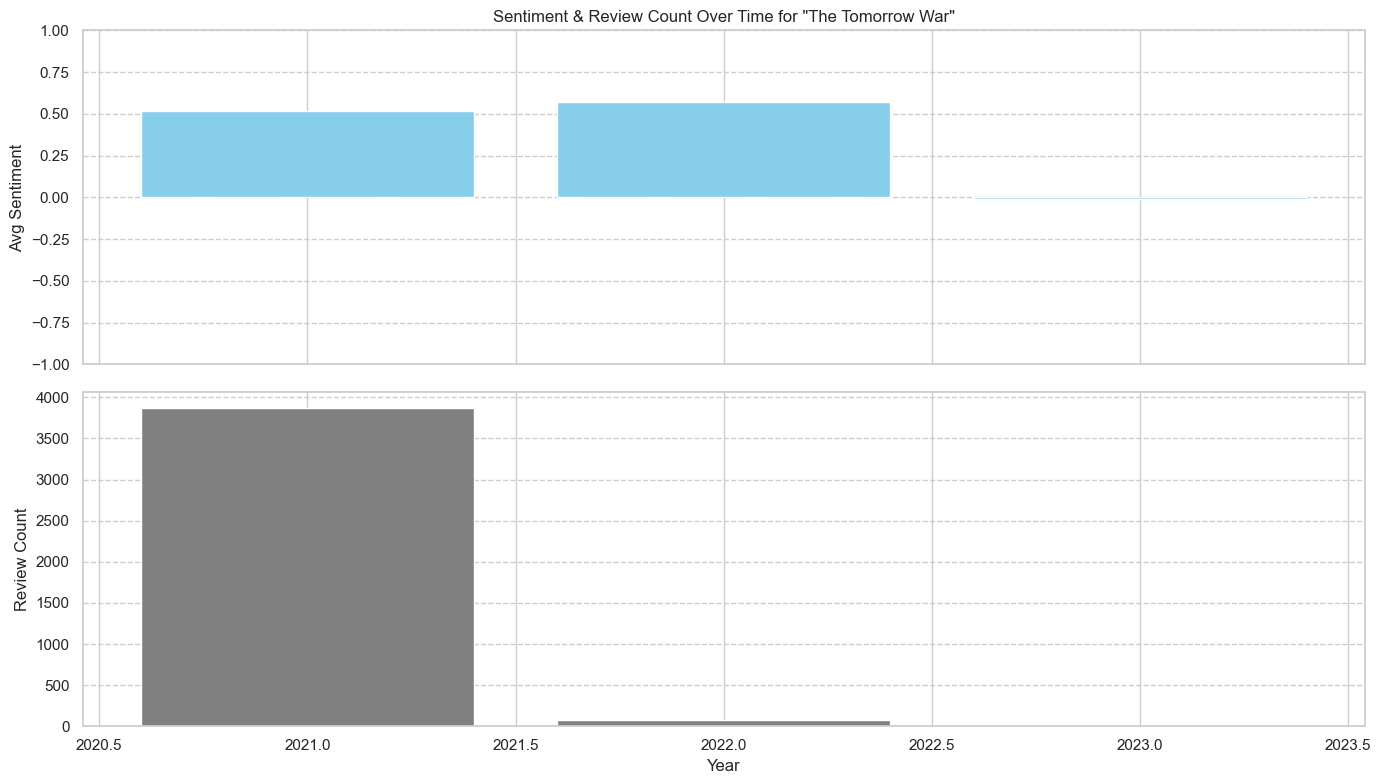

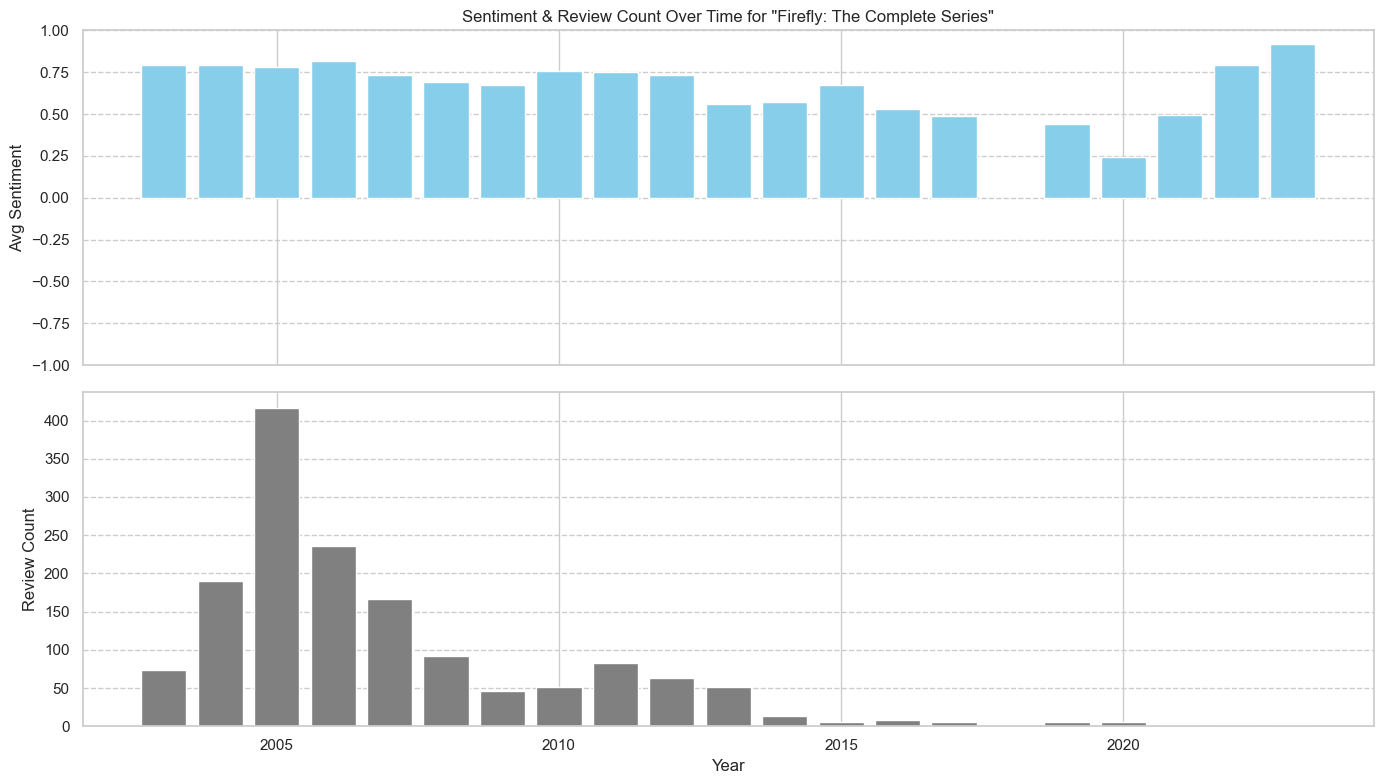

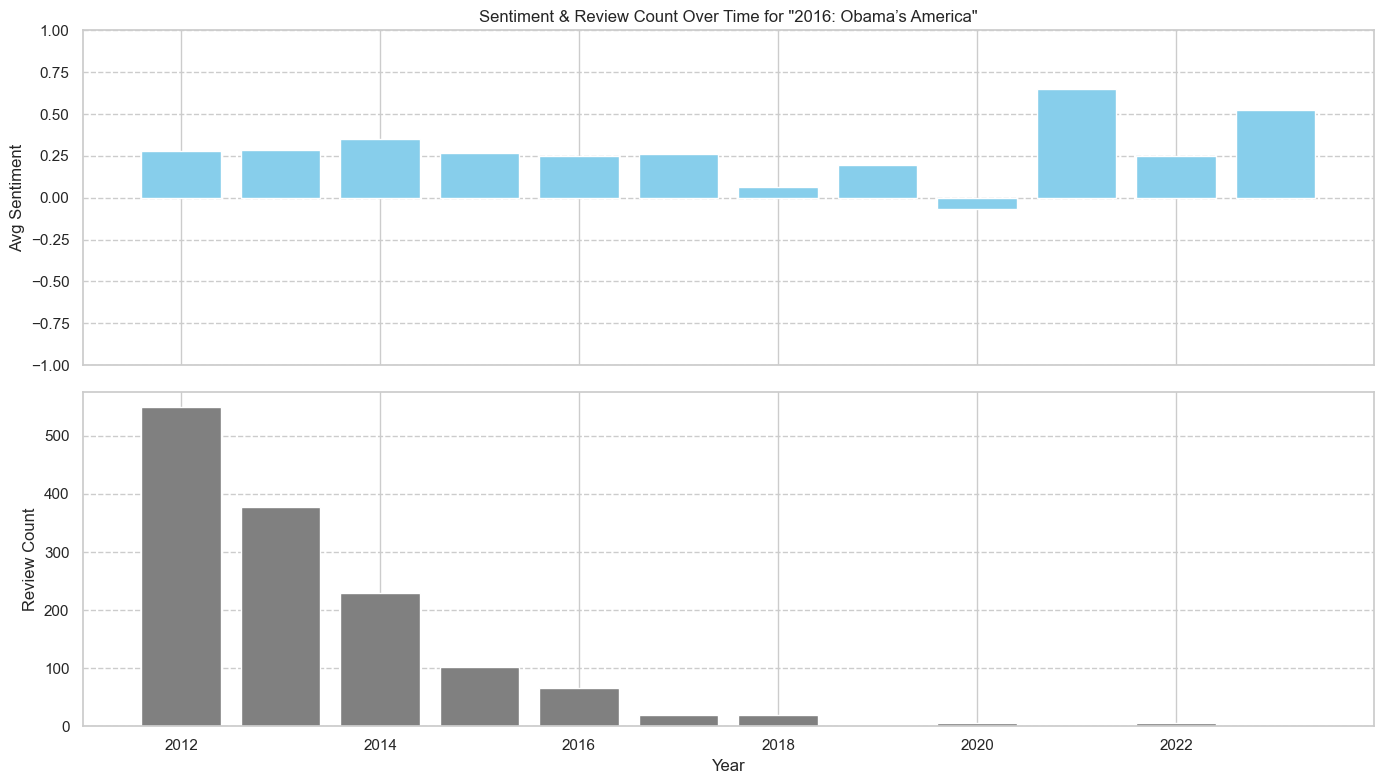

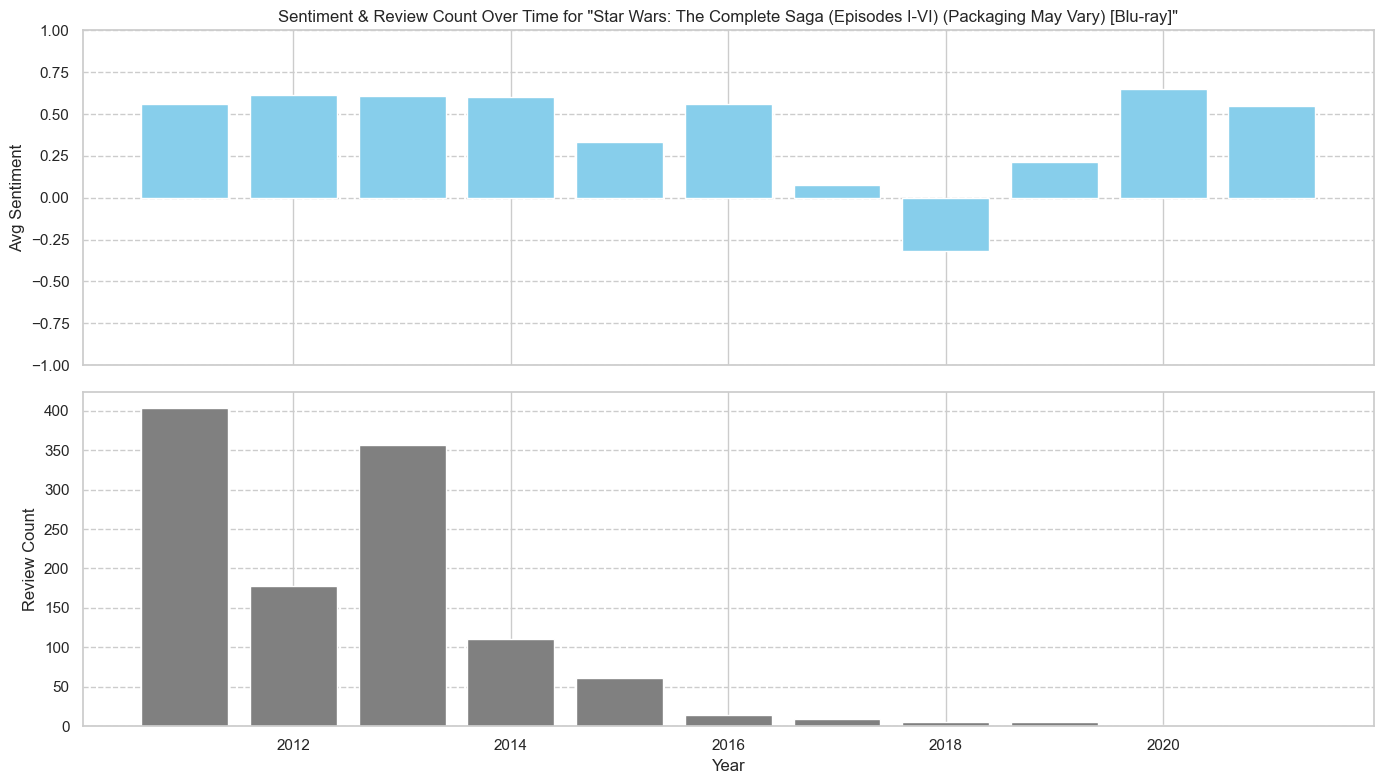

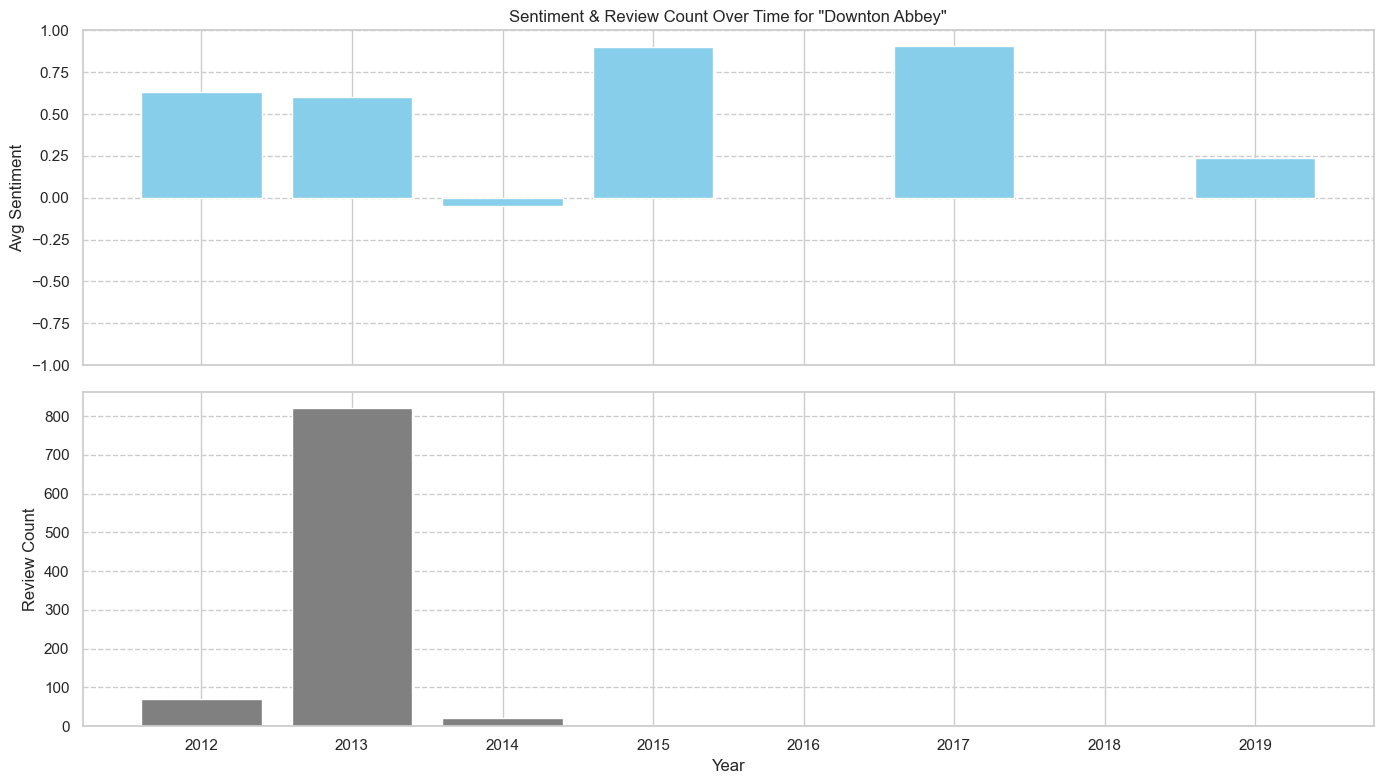

In [ ]:
for item in top_5:
    df_item = df[df["parent_asin"] == item].copy()

    # Convert Unix timestamps to date (from ms to datetime.year) # not sure if that is the best call, but 
    df_item["date"] = pd.to_datetime(df_item["timestamp"], unit='ms').dt.year

    avg_sentiment = df_item.groupby("date")["sentiment_score"].mean()
    review_count = df_item.groupby("date")["sentiment_score"].count()

    # Create subplots
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 8), sharex=True)

    # Plot 1: Sentiment
    ax1.bar(avg_sentiment.index, avg_sentiment.values, color='skyblue')
    ax1.set_ylabel("Avg Sentiment")
    ax1.set_title(f"Sentiment & Review Count Over Time for \"{df_item["title_y"].to_list()[0]}\"")
    ax1.set_ylim(-1, 1)
    ax1.grid(True, axis='y', linestyle='--')

    # Plot 2: Review Count
    ax2.bar(review_count.index, review_count.values, color='gray')
    ax2.set_ylabel("Review Count")
    ax2.set_xlabel("Year")
    ax2.grid(True, axis='y', linestyle='--')

    plt.tight_layout()
    plt.show()

# Based on most reviewed in the selected comunities

In [14]:
with open('communities.json', 'r') as file:
    communities_full = json.load(file)
communities_filtered = {k: v for k, v in communities_full.items() if len(v) > 100}
communities_filtered.keys()

dict_keys(['44', '1', '2', '3', '5', '147', '8', '9', '10', '11', '13', '17', '37'])

In [16]:
def normalize_title(title):
    if not isinstance(title, str):
        return ''
    title = title.lower()
    
    # Keep part after comma if it exists and the part after is short (likely the title)
    if ',' in title:
        parts = title.split(',')
        if len(parts[1].strip().split()) <= 4:
            title = parts[1]
    
    title = re.sub(r'\[.*?\]', '', title)              # remove [DVD], [Blu-ray], etc.
    title = re.sub(r'\(.*?edition\)', '', title)       # remove (Special Edition), etc.
    title = re.sub(r'\(.*?format\)', '', title)        # remove other bracketed formats
    title = re.sub(r'[^a-z0-9\s]', '', title)          # remove punctuation
    title = re.sub(r'\s+', ' ', title).strip()         # normalize whitespace
    return title

def get_top_titles_for_community(community_asins, df, top_n=10):
    df['rating_number'] = df['rating_number'].apply(pd.to_numeric, errors='coerce')
    matching_rows = df[df['parent_asin'].isin(community_asins)]
    
    deduped = matching_rows.sort_values('rating_number', ascending=False).drop_duplicates('parent_asin')
    
    top_rows = deduped.sort_values('rating_number', ascending=False)
    top_rows = top_rows[top_rows['movie_title'].notna()]
    
    seen = set()
    unique_top_titles = []
    
    for _, row in top_rows.iterrows():
        norm_title = normalize_title(row['movie_title'])
        if norm_title not in seen:
            seen.add(norm_title)
            unique_top_titles.append((row['movie_title'], row['rating_number']))
        if len(unique_top_titles) >= top_n:
            break

    return unique_top_titles


In [25]:
# Test it here:
focus_list = []
for community_id in communities_filtered.keys():
    asin_list = communities_filtered[community_id]
    top_titles = get_top_titles_for_community(asin_list, df)
    for t in top_titles:
        focus_list.append(t)
        break
focus_list

[('The Green Mile (Single Disc Edition)', 14610.0),
 ('HOCUS POCUS [Blu-ray]', 85694.0),
 ('Yellowstone: Season One', 152203.0),
 ('Dirty Dancing', 38048.0),
 ('Harry Potter and the Prisoner of Azkaban (Two-Disc Widescreen Edition)',
  58957.0),
 ("National Lampoon's Christmas Vacation [Blu-ray]", 127938.0),
 ('The Grand Tour', 89785.0),
 ('Free Guy', 103290.0),
 ('Frozen', 77609.0),
 ('Deliver Us From Evil', 6143.0),
 ('Contagion (DVD)', 58926.0),
 ('American Sniper Special Edition (DVD)', 46682.0),
 ('Masterpiece Classic: Downton Abbey, Season 3 [Blu-ray]', 38822.0)]

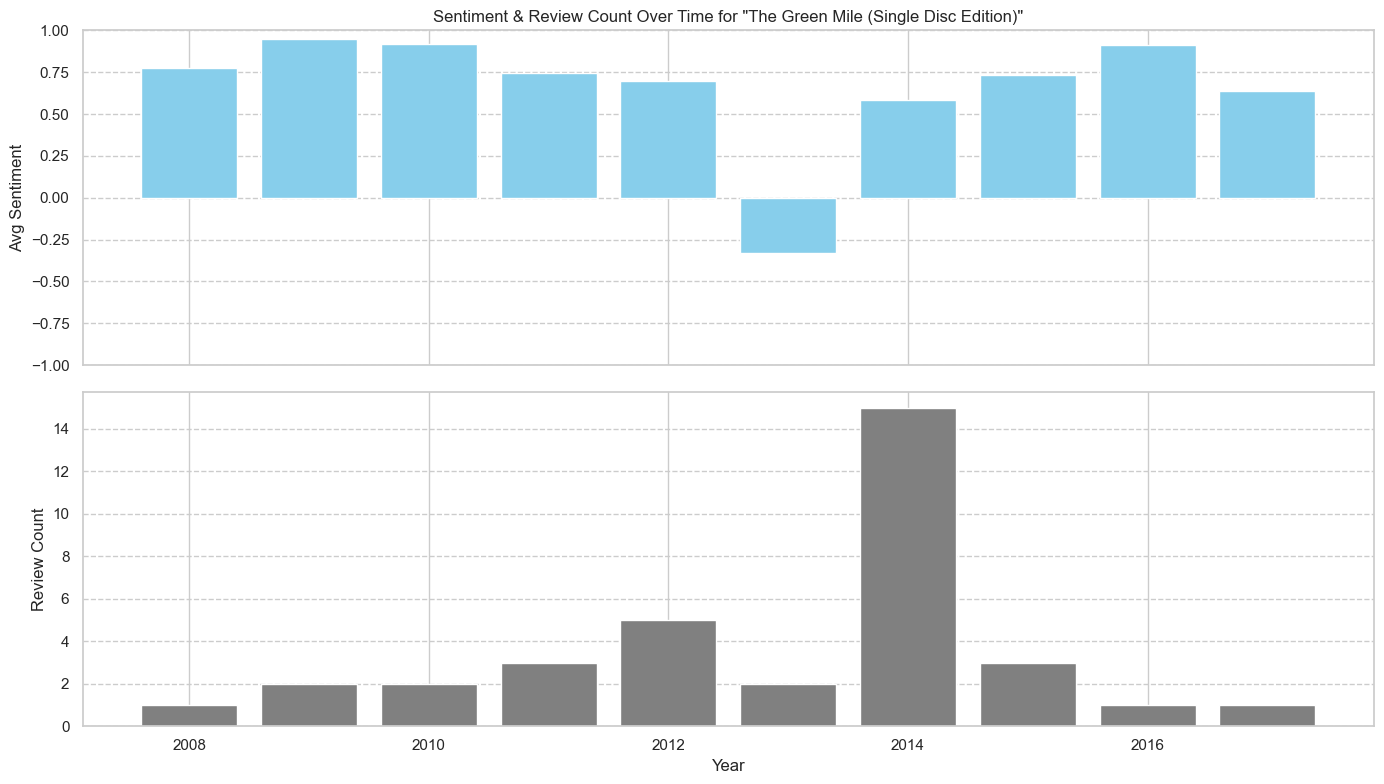

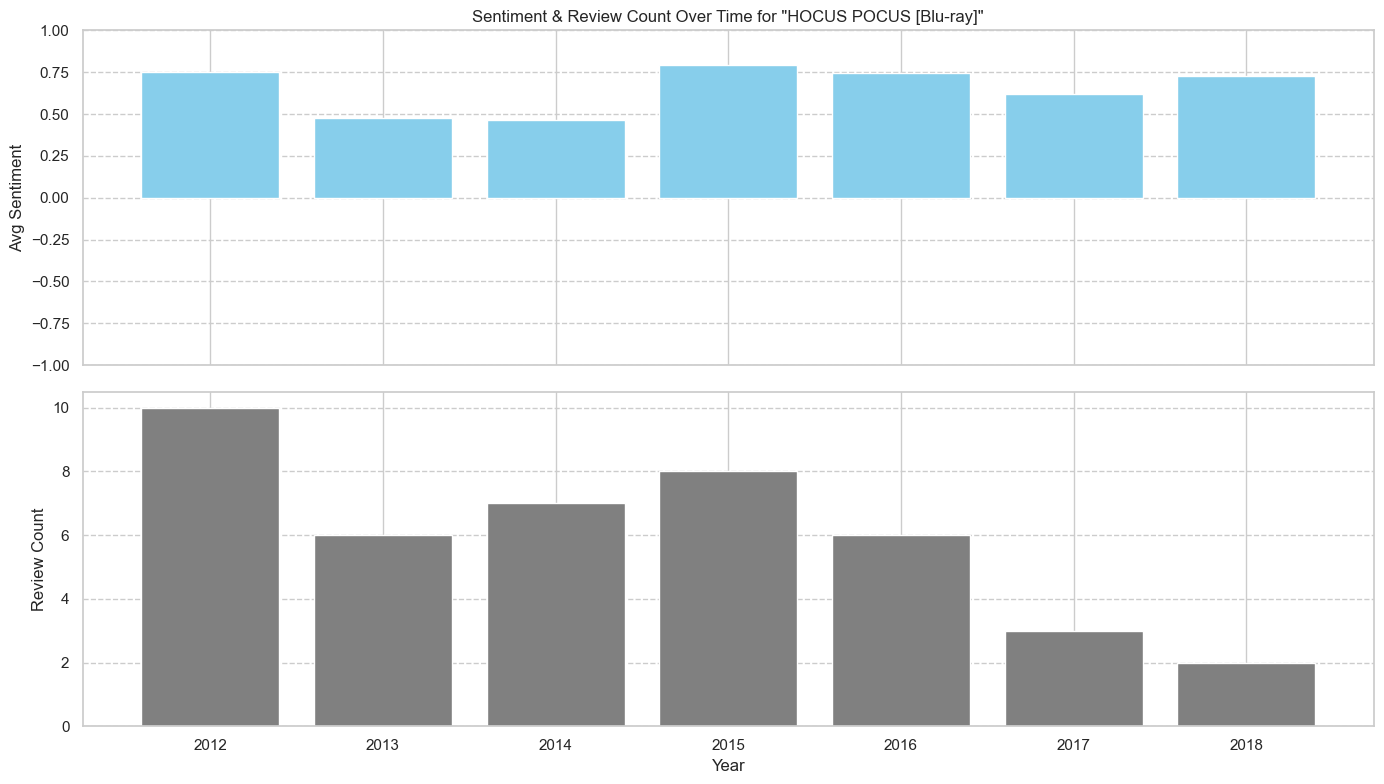

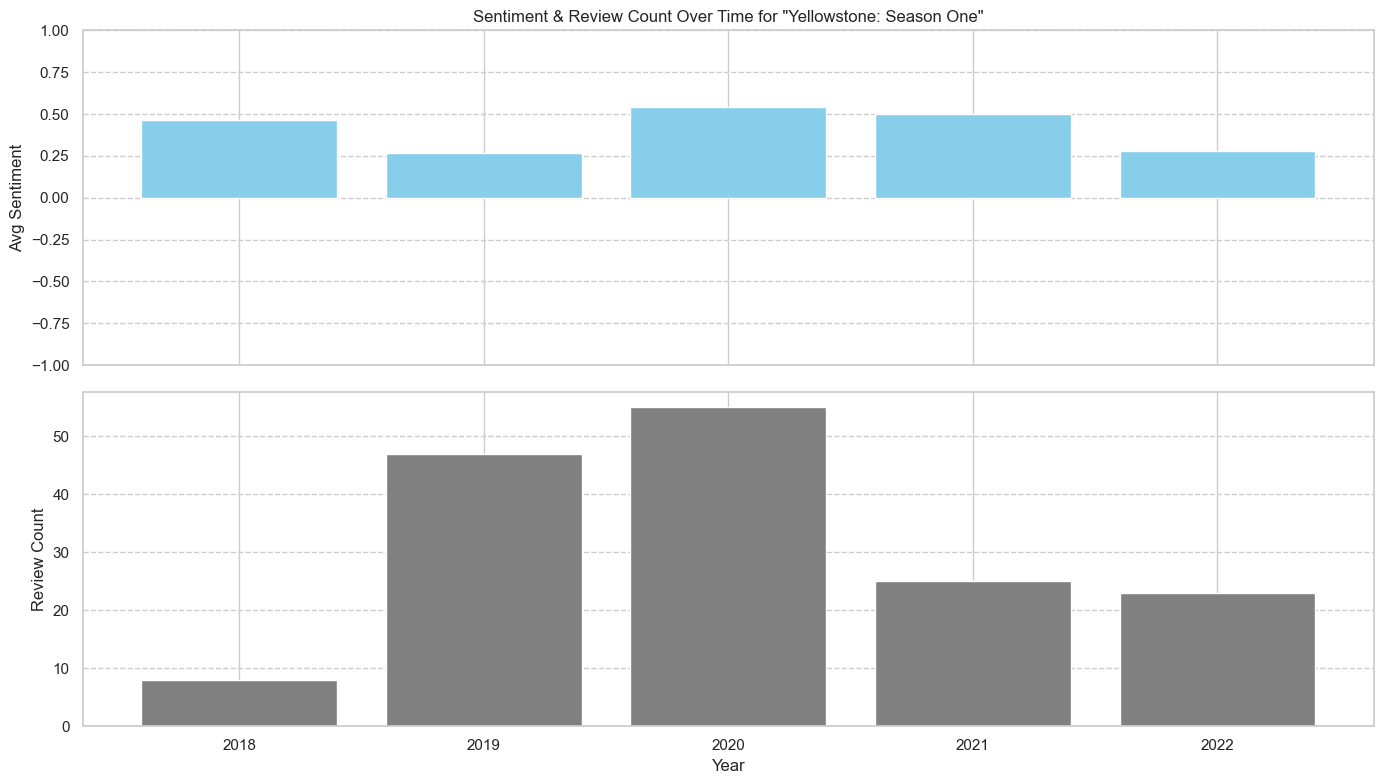

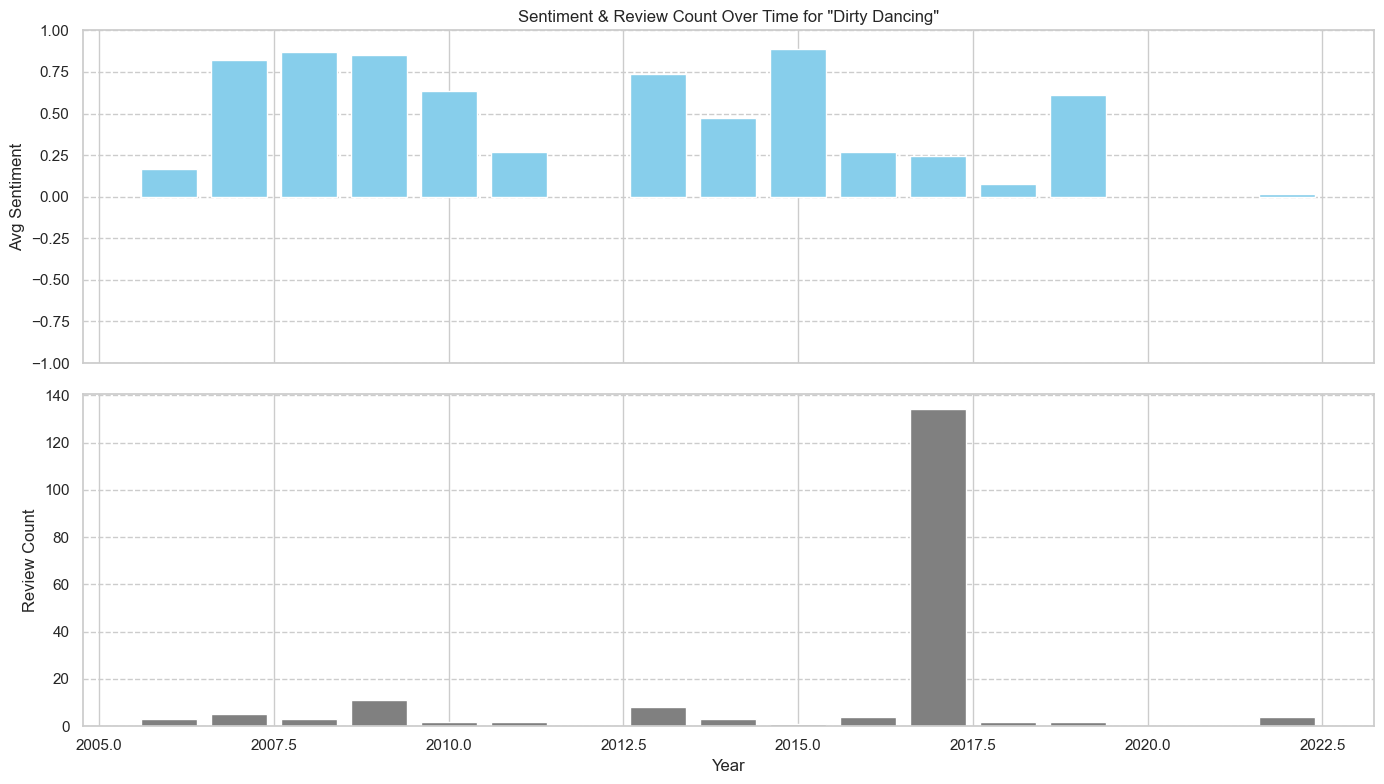

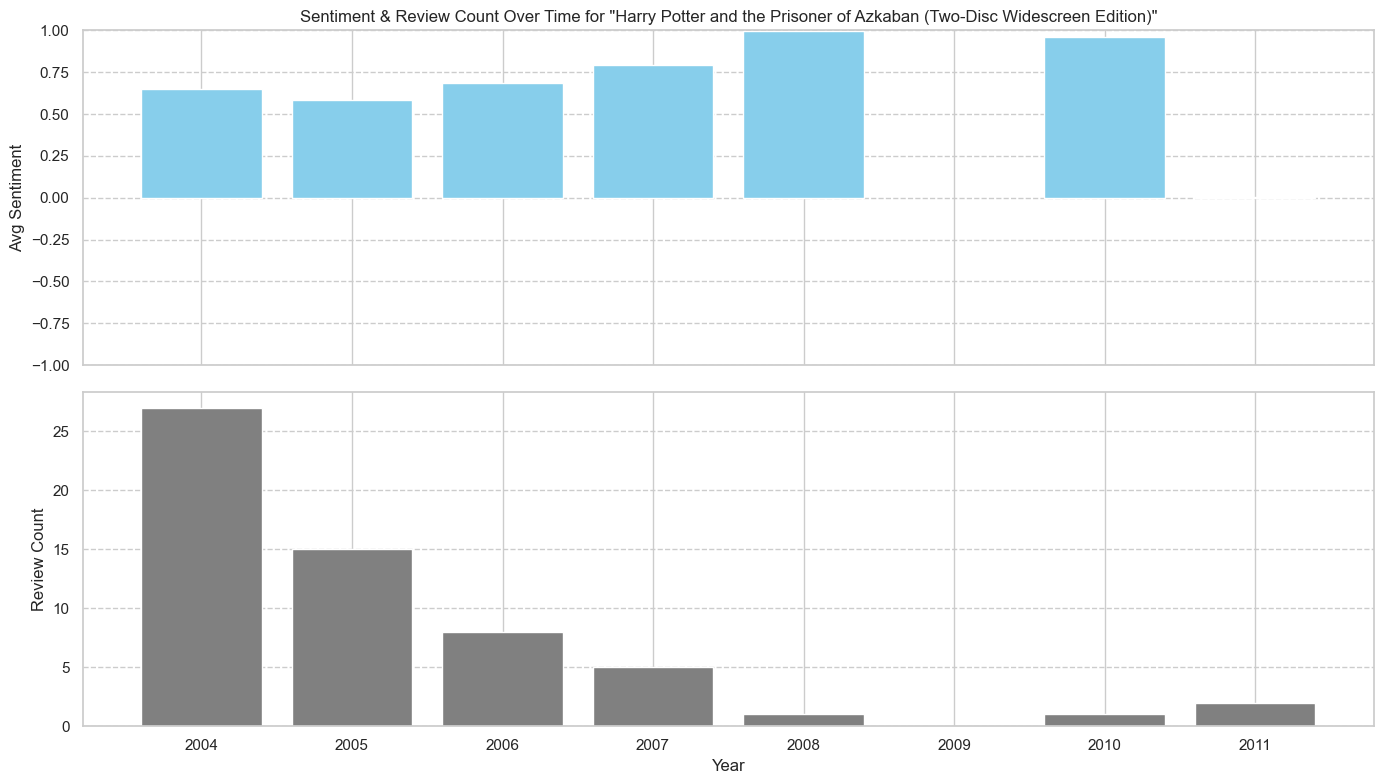

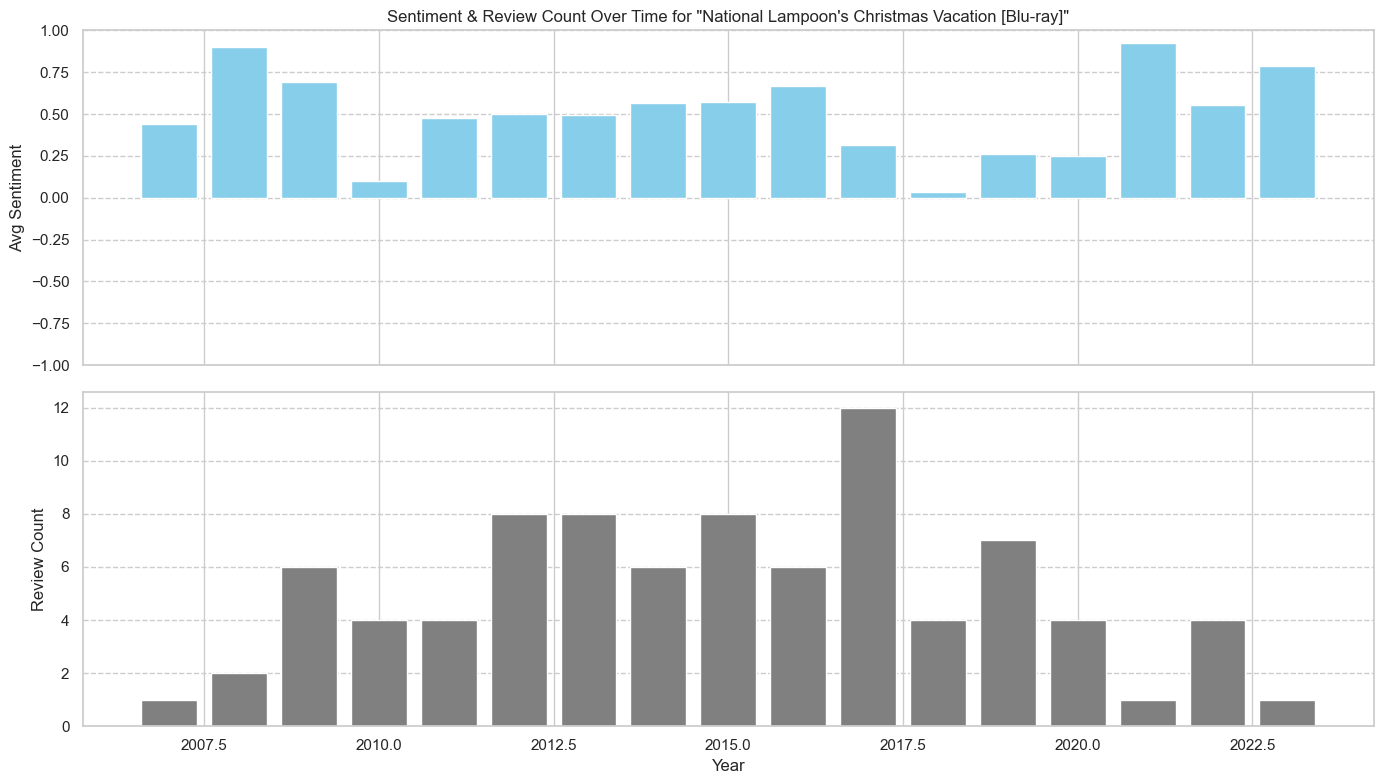

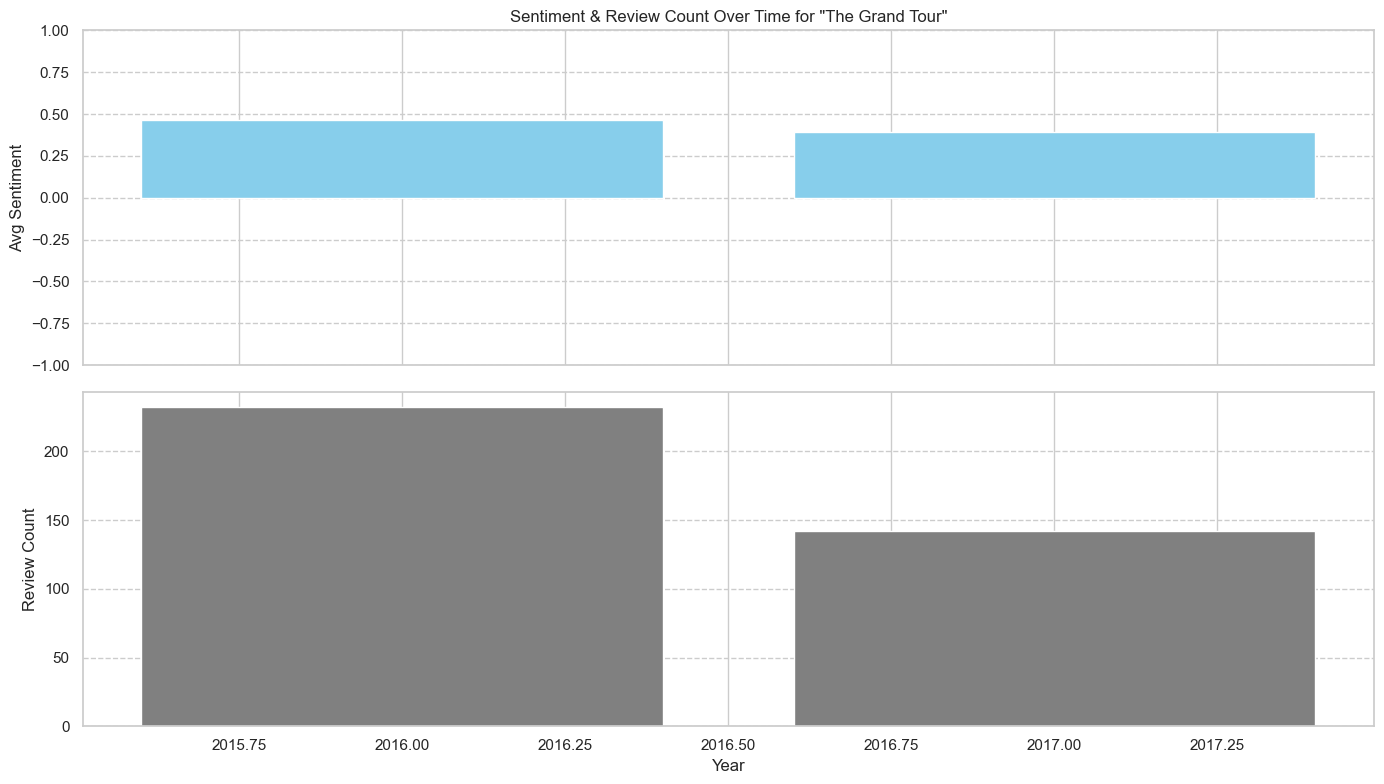

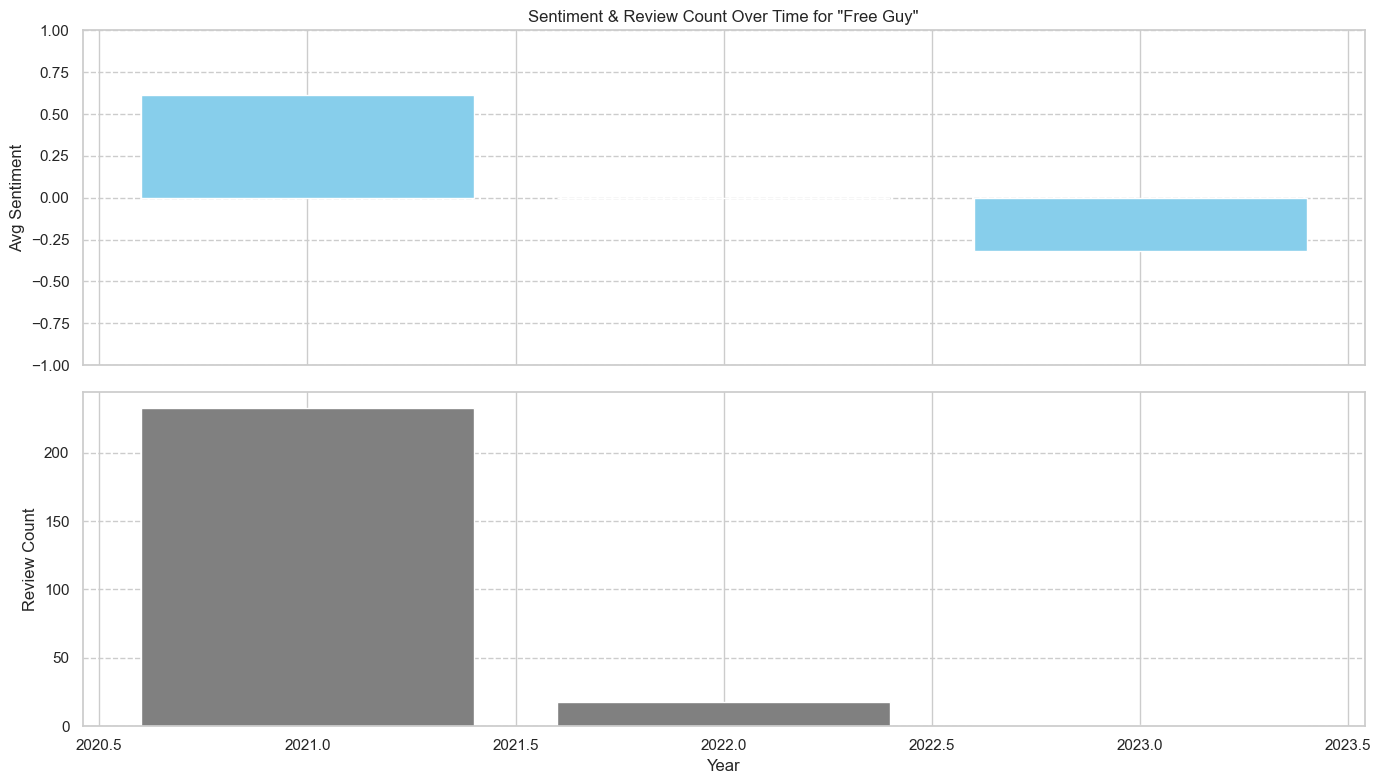

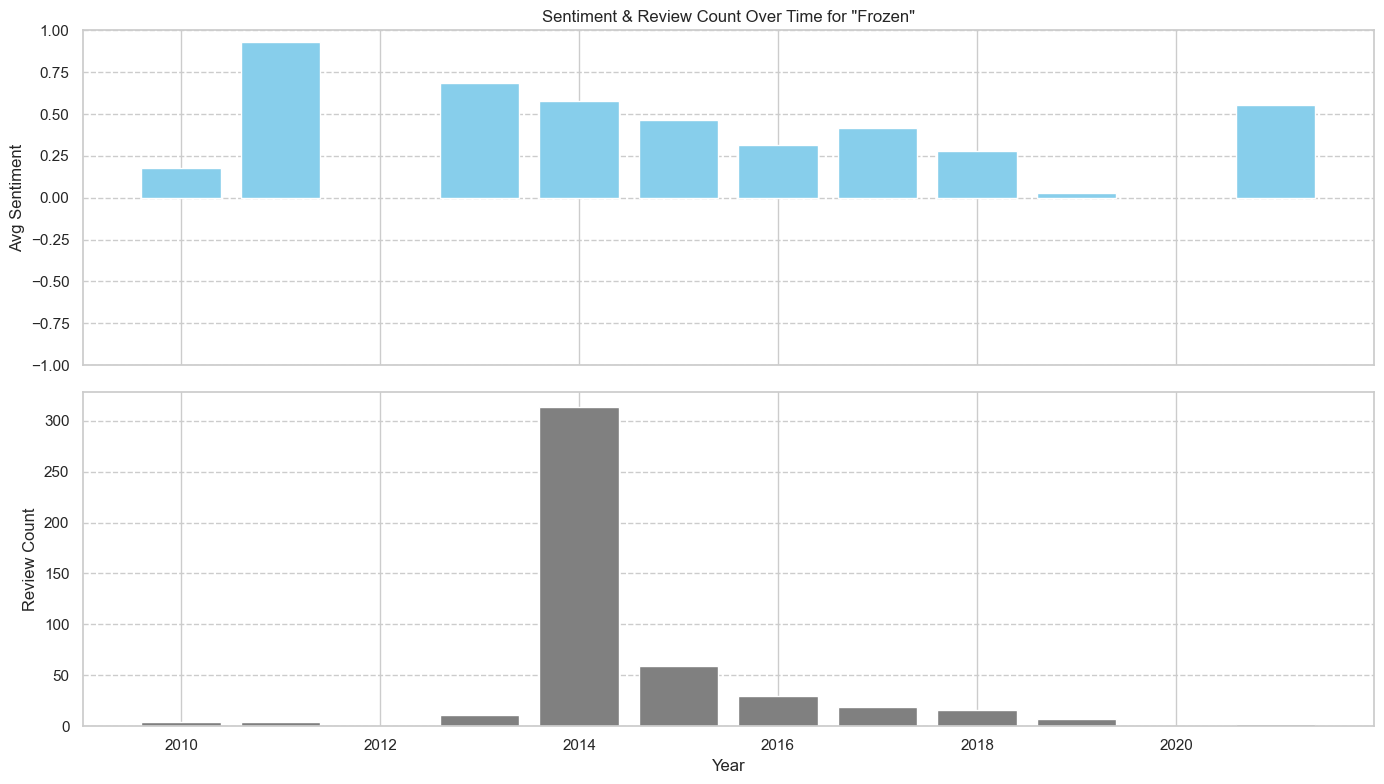

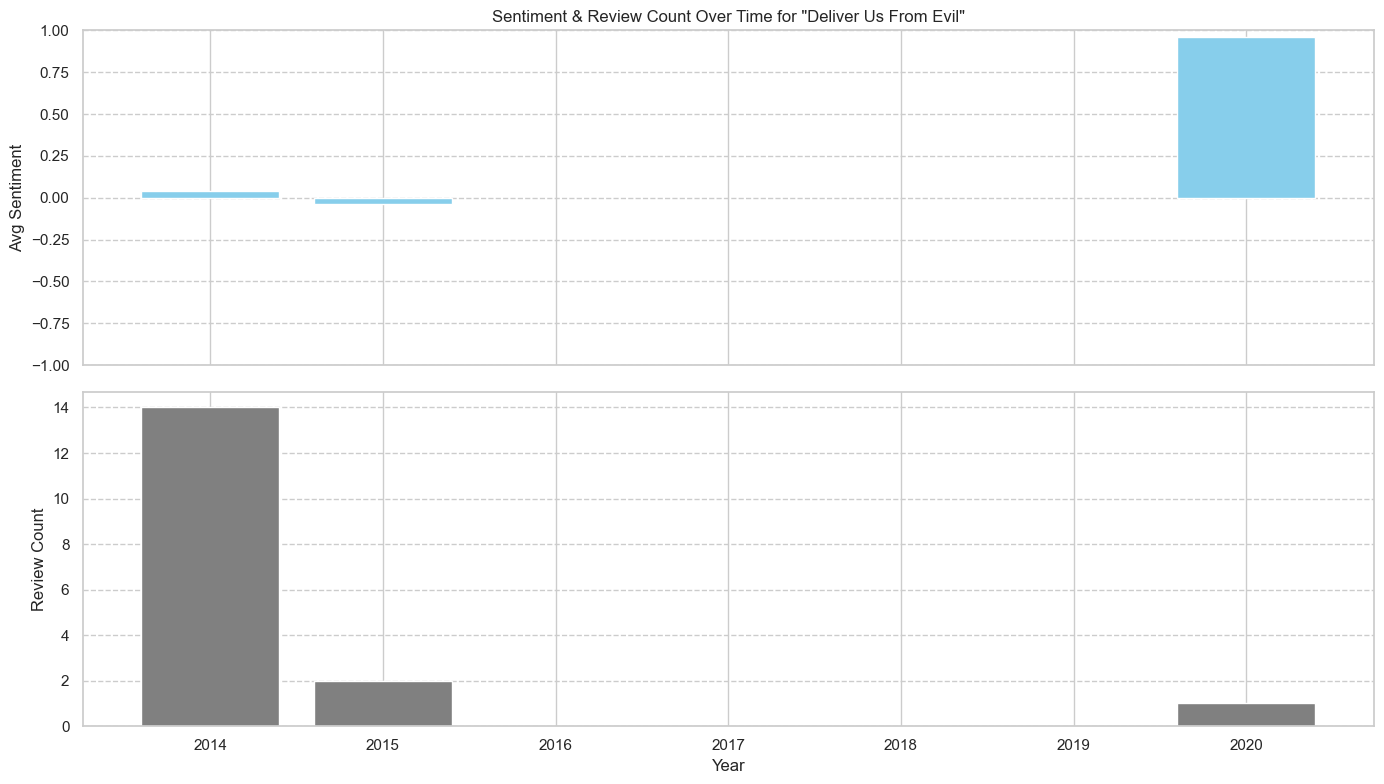

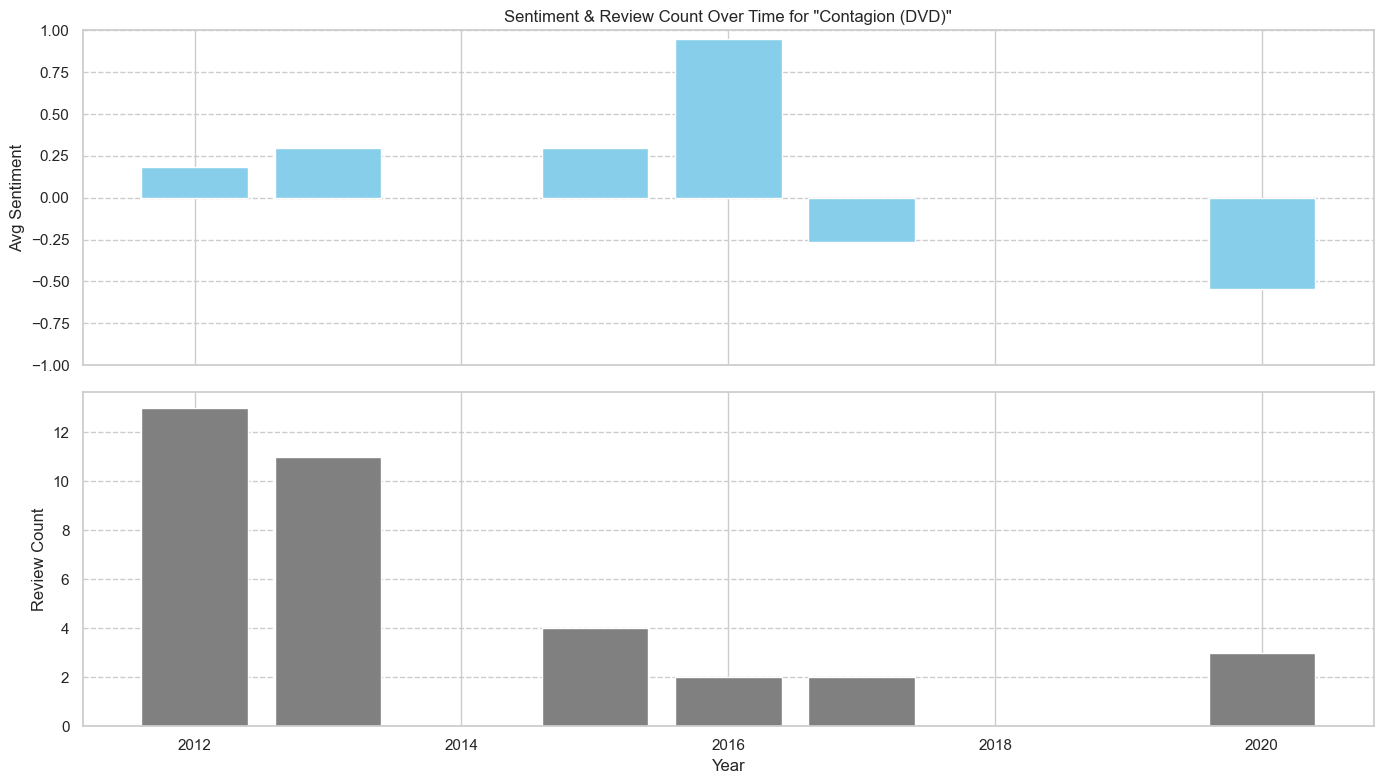

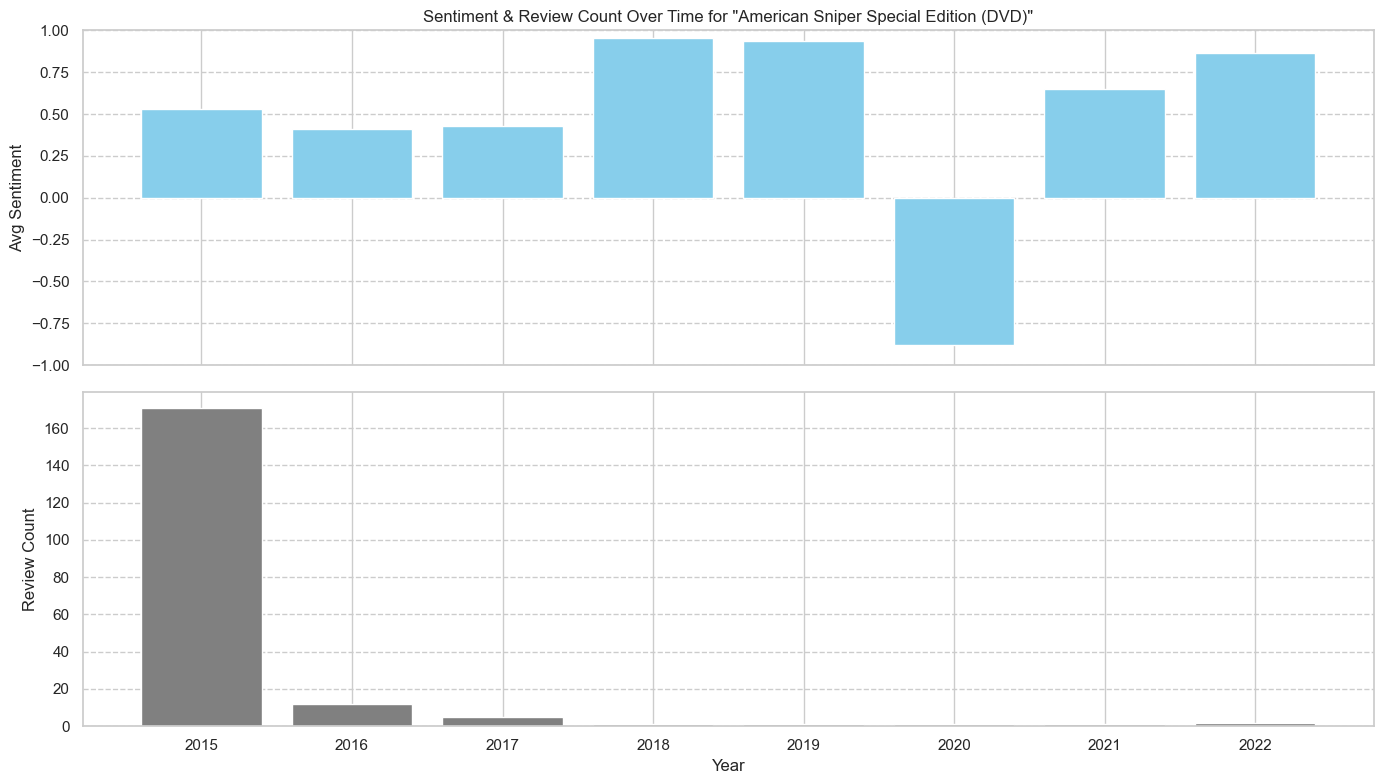

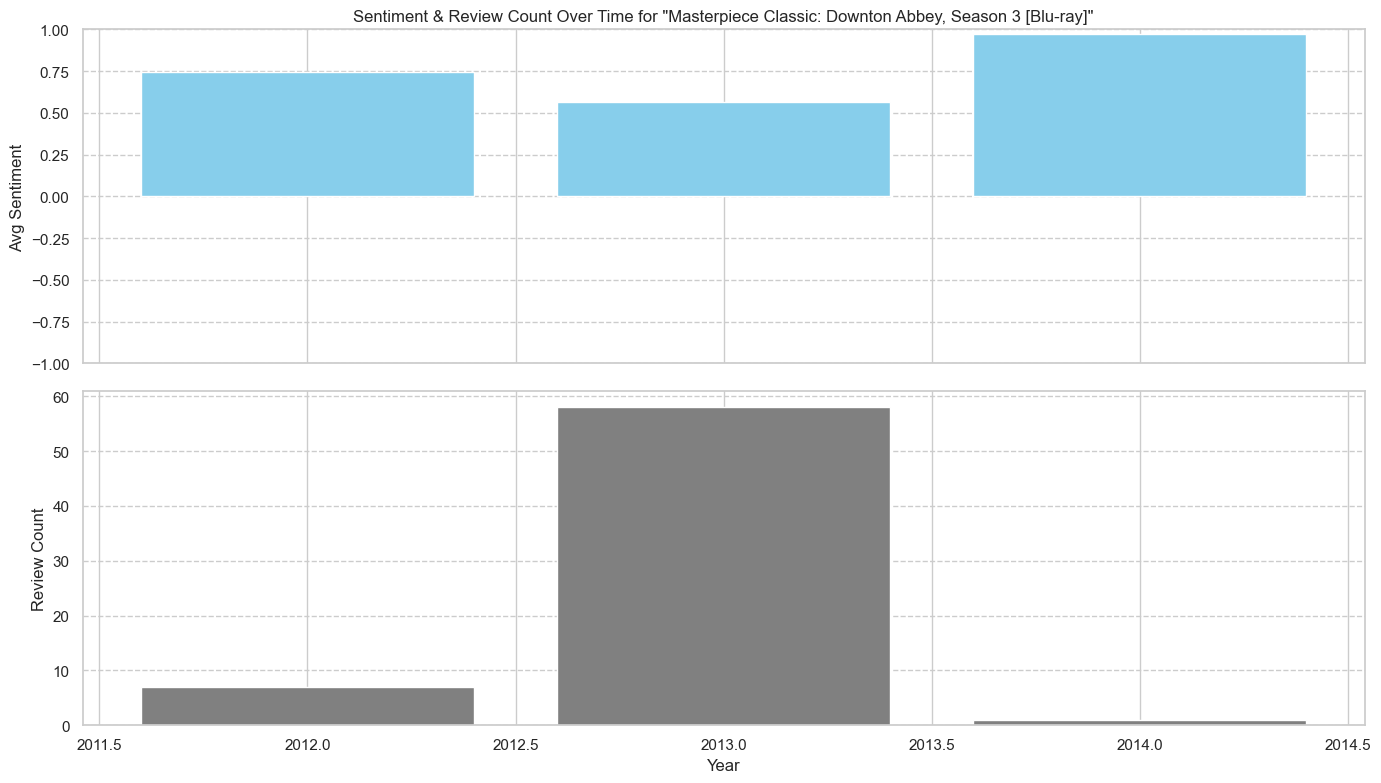

In [27]:
for movie, _ in focus_list:
    # movie = str(movie)

    df_item = df[df["movie_title"] == movie].copy()

    # Convert Unix timestamps to date (from ms to datetime.year) # not sure if that is the best call, but 
    df_item["date"] = pd.to_datetime(df_item["timestamp"], unit='ms').dt.year

    avg_sentiment = df_item.groupby("date")["sentiment_score"].mean()
    review_count = df_item.groupby("date")["sentiment_score"].count()

    # Create subplots
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 8), sharex=True)

    # Plot 1: Sentiment
    ax1.bar(avg_sentiment.index, avg_sentiment.values, color='skyblue')
    ax1.set_ylabel("Avg Sentiment")
    ax1.set_title(f"Sentiment & Review Count Over Time for \"{movie}\"")
    ax1.set_ylim(-1, 1)
    ax1.grid(True, axis='y', linestyle='--')

    # Plot 2: Review Count
    ax2.bar(review_count.index, review_count.values, color='gray')
    ax2.set_ylabel("Review Count")
    ax2.set_xlabel("Year")
    ax2.grid(True, axis='y', linestyle='--')

    plt.tight_layout()
    plt.show()